# Problem of the Week 7

Name: Adarsh Mallya

Student ID: 017086225

Date: 10/05/2025

**Motivation**

This week's Problem of the Week is focused on comparing and contrasting the single- and multi-layer perceptrons.

**Completing this assignment**

Fill in the coding and markdown cells as indicated below. When you are happy with you responses, restart the kernel and run all cells to produce a clean rendition of your notebook. Then, create a PDF of your notebook and upload both documents (PDF and ipynb file) to Canvas.

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import struct

# modules from PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

if torch.cuda.is_available():
    device_name = "cuda"
elif torch.backends.mps.is_available():
    device_name = "mps"
else:
    device_name = "cpu"
print('Using device: '+device_name)
device = torch.device(device_name)

Using device: mps


## Problem 7.1

In class, we created two classes - one for the single layer perceptron and one for the multi layer perceptron. Copy those classes over here.

In [4]:
# copy the single layer perceptron code here
class SLP(nn.Module):

    # define an init function with a Linear layer
    def __init__(self, in_dim=784, out_dim=10):
        super().__init__()
        self.fc = nn.Linear(in_dim, out_dim)

    # implement the forward method
    def forward(self, x):
        out = torch.sigmoid(self.fc(x))
        return out

In [5]:
# copy the multilayer perceptron code here
class MLP(nn.Module):

    def __init__(self, in_dim=784, hidden_dim=50, out_dim=10):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        h = torch.sigmoid(self.fc1(x))
        out = torch.sigmoid(self.fc2(h))
        return out

## Problem 7.2

In class, we introduced the MNIST hand-written image database. Read in the data here and prepare it for use in your Perceptron code.

In [6]:
# load in the MNIST hand-written image database
def read_mnist_images(data_directory, subset='train'):
    if subset=='train':
        prefix = 'train-'
    else:
        prefix = 't10k-'
        
    with open(os.path.join('MNIST',prefix+'images.idx3-ubyte'), 'rb') as f:
        # unpack header
        _, num_images, num_rows, num_cols = struct.unpack('>IIII', f.read(16))
        
        # read image data
        image_data = f.read(num_images * num_rows * num_cols)
        images = np.frombuffer(image_data, dtype=np.uint8)
        images = images.reshape(num_images, num_rows, num_cols)

    with open(os.path.join('MNIST',prefix+'labels.idx1-ubyte'), 'rb') as f:
        # unpack header
        _, num_labels = struct.unpack('>II', f.read(8))

        # read label data
        labels = np.frombuffer(f.read(), dtype=np.uint8)

        
    return images, labels

In [7]:
# load in the training and test images
train_images, train_labels = read_mnist_images('MNIST','train')
test_images, test_labels = read_mnist_images('MNIST','test')

# reshape as before
X_train = train_images.reshape(-1, 784) / 255.0
X_test = test_images.reshape(-1, 784) / 255.0
y_train = train_labels
y_test = test_labels

# create PyTorch tensor versions of the MNIST data
X_train_tensor = torch.tensor(X_train).float()
y_train_tensor = torch.tensor(y_train).float()
X_test_tensor = torch.tensor(X_test).float()
y_test_tensor = torch.tensor(y_test).float()

# create one-hot encoded training label tensors
y_train_onehot = F.one_hot(y_train_tensor.to(torch.int64), num_classes=10).float()
y_test_onehot = F.one_hot(y_test_tensor.to(torch.int64), num_classes=10).float()

# make a TensorDataset object for the training data
ds_train = TensorDataset(X_train_tensor, y_train_onehot)

# make a loader object for the training data
train_loader = DataLoader(ds_train, batch_size=64, shuffle=True)

# make a TensorDataset object for the test data
ds_test = TensorDataset(X_test_tensor, y_test_onehot)

# make a loader object for the test data
test_loader = DataLoader(ds_test, batch_size=64, shuffle=False)

## Problem 7.3

Generate models for each of the perceptrons, and train each model with an equivalent learning rate and number of iterations.

In [13]:
# create an slp object and train it
slp = SLP().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(slp.parameters(), lr=0.5)
slp_train_losses = []
slp_train_accs = []
slp_test_losses = []
slp_test_accs = []

# loop through each epoch
for epoch in range(50):

    #- Testing Block --------------------------------
    slp.train()
    total_loss, correct, total = 0, 0, 0

    # loop through mini-batches in the data loader
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)

        # forward
        p = slp(x)
        
        # backward
        loss = criterion(p, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # compute the total loss
        total_loss += loss.item() * x.size(0)

        # predictions (argmax across 10 classes)
        pred = p.argmax(dim=1)
        true = y.argmax(dim=1)
        correct += (pred == true).sum().item() 
        total += x.size(0)

    train_loss = total_loss/total
    train_acc = correct/total
    slp_train_losses.append(train_loss)
    slp_train_accs.append(train_acc)

    if (epoch + 1) % 5 == 0:
        print(f"epoch {epoch+1}: loss={total_loss/total:.4f}, acc={correct/total:.3f}")

    # ---- Evaluation (Testing/Validation) ----
    slp.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)

            p = slp(x)
            loss = criterion(p, y)

            total_loss += loss.item() * x.size(0)

            pred = p.argmax(dim=1)
            true = y.argmax(dim=1)
            correct += (pred == true).sum().item() 
            total += x.size(0)

    test_loss = total_loss/total
    test_acc = correct/total
    slp_test_losses.append(test_loss)
    slp_test_accs.append(test_acc)

epoch 5: loss=0.0319, acc=0.870
epoch 10: loss=0.0259, acc=0.886
epoch 15: loss=0.0234, acc=0.895
epoch 20: loss=0.0219, acc=0.901
epoch 25: loss=0.0208, acc=0.903
epoch 30: loss=0.0200, acc=0.907
epoch 35: loss=0.0194, acc=0.909
epoch 40: loss=0.0189, acc=0.911
epoch 45: loss=0.0184, acc=0.913
epoch 50: loss=0.0180, acc=0.915


In [14]:
# create an mlp object and train it
mlp = MLP().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(mlp.parameters(), lr=0.5)

mlp_train_losses = []
mlp_train_accs = []
mlp_test_losses = []
mlp_test_accs = []

# loop through each epoch
for epoch in range(50):

    #- Testing Block --------------------------------
    mlp.train()
    total_loss, correct, total = 0, 0, 0

    # loop through mini-batches in the data loader
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        # forward
        p = mlp(x)
        
        # backward
        loss = criterion(p, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # compute the total loss
        total_loss += loss.item() * x.size(0)
        # predictions (argmax across 10 classes)
        pred = p.argmax(dim=1)
        true = y.argmax(dim=1)
        correct += (pred == true).sum().item() 
        total += x.size(0)
        
    train_loss = total_loss/total
    train_acc = correct/total
    mlp_train_losses.append(train_loss)
    mlp_train_accs.append(train_acc)
    if (epoch + 1) % 5 == 0:
        print(f"epoch {epoch+1}: loss={total_loss/total:.4f}, acc={correct/total:.3f}")
    # ---- Evaluation (Testing/Validation) ----
    mlp.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            p = mlp(x)
            loss = criterion(p, y)
            total_loss += loss.item() * x.size(0)
            pred = p.argmax(dim=1)
            true = y.argmax(dim=1)
            correct += (pred == true).sum().item() 
            total += x.size(0)
    test_loss = total_loss/total
    test_acc = correct/total
    mlp_test_losses.append(test_loss)
    mlp_test_accs.append(test_acc)

epoch 5: loss=0.0306, acc=0.864
epoch 10: loss=0.0195, acc=0.899
epoch 15: loss=0.0163, acc=0.911
epoch 20: loss=0.0146, acc=0.919
epoch 25: loss=0.0135, acc=0.925
epoch 30: loss=0.0126, acc=0.930
epoch 35: loss=0.0119, acc=0.933
epoch 40: loss=0.0113, acc=0.937
epoch 45: loss=0.0108, acc=0.940
epoch 50: loss=0.0104, acc=0.943


## Problem 7.4

Generate two plots to compare and contrast the losses and accuracies of the perceptrons. The left plot should show two lines - one for the test losses of the single layer perceptron (blue) and one for the multi layer perceptron (orange). The right plot should be identical, but it should show the accuracies. Be sure to add a legend to your plot and label your axes.

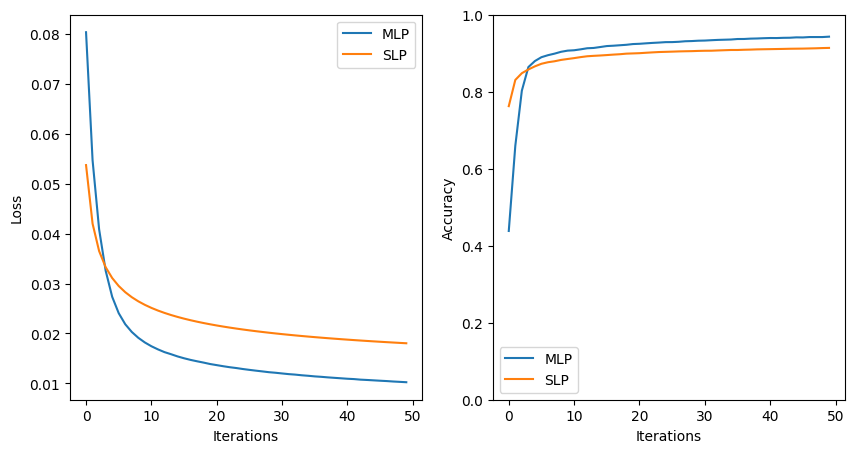

In [15]:
# create your plots here
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(mlp_test_losses,label='MLP')
plt.plot(slp_test_losses,label='SLP')
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.legend()

plt.subplot(1,2,2)
plt.plot(mlp_test_accs,label='MLP')
plt.plot(slp_test_accs,label='SLP')
plt.legend()
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.xlabel('Iterations')
plt.show()

## Problem 7.5

Based on the plot you've made above, answer the following questions:
1. What evidence do you see in yout plots to convince you that your model has converged?
2. Which model converged quicker?
3. Which model is more accurate? Explain why this model is more accurate (3 sentences max).

1. The plots both show a convergence of the loss towards zero and a convergence of the accuracies towards some static value, which means that the models have converged.
2. The SLP model converged quicker, as it plateaued at less iterations than the MLP did.
3. The MLP model is more accurate, as it was able to minimize the loss further than the SLP did.